In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import os
import glob
import json
from scipy.stats import pearsonr, linregress
from scipy.stats import gaussian_kde

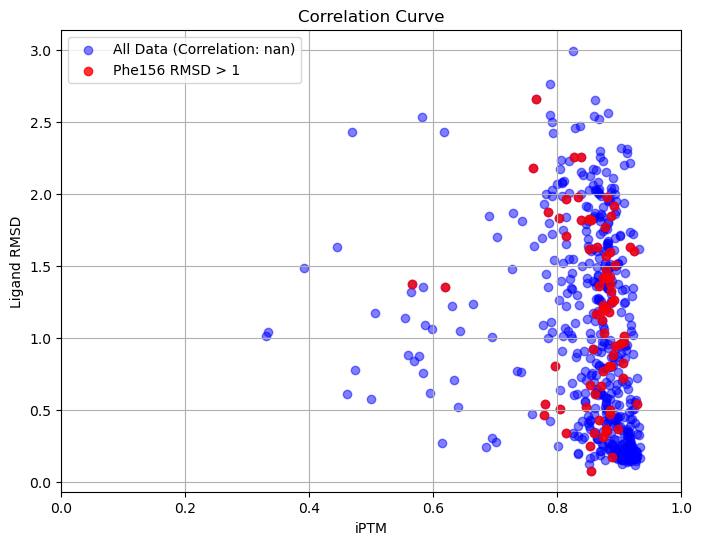

In [2]:
#Aim: Plot Ligand RMSD against ipTM and add Phe156 > 1 A as a filter to see if this conformation difference affects the
#true positive and false positive rates.

file_path = "/Users/JB/Rotation_bkslab/250115_chaifold/20241209_mac1.xlsx"  
data = pd.read_excel(file_path)

# Extract columns
y1 = data.iloc[:, 9]  # Full dataset (Ligand RMSD)
x = data.iloc[:, 15]  # iPTM (independent variable)
z = data.iloc[:, 24]  # Phe156 backbone RMSD

# Filter data for y2 (where Phe156 backbone RMSD > 156)
filtered_data = data.loc[data["Phe156 backbone RMSD"] > 1] 
x_filtered = filtered_data.iloc[:, 15]  # Corresponding iPTM values
y2 = filtered_data.iloc[:, 9]  # Corresponding Ligand RMSD values

# Calculate correlation coefficient
correlation_coefficient = np.corrcoef(x, y1)[0, 1]

# Plot the correlation curve
plt.figure(figsize=(8, 6))
plt.scatter(x, y1, color='blue', alpha=0.5, label=f'All Data (Correlation: {correlation_coefficient:.2f})')
plt.scatter(x_filtered, y2, color='red', alpha=0.8, label="Phe156 RMSD > 1")

# Labels and formatting
plt.title('Correlation Curve')
plt.xlabel('iPTM')
plt.ylabel('Ligand RMSD')
plt.xlim(0, 1)
plt.legend()
plt.grid(True)

# Show plot
plt.show()

/var/folders/6v/7hycfbhs6fg9jp_q0z6h9flm0000gp/T/ipykernel_34829/4183794198.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats = df.groupby("ipTM Group")["Ligand RMSD"].agg(["mean", "std"])


Number of data points in each ipTM bin:
ipTM Group
<70         4
70-80       8
80-90     138
90-100    401
Name: count, dtype: int64
                mean       std
ipTM Group                    
<70         1.291448  0.313419
70-80       1.778486  0.863193
80-90       1.374016  0.657785
90-100      0.881057  0.633545
Pearson Correlation Coefficient: -0.404
P-value: 4.219e-23


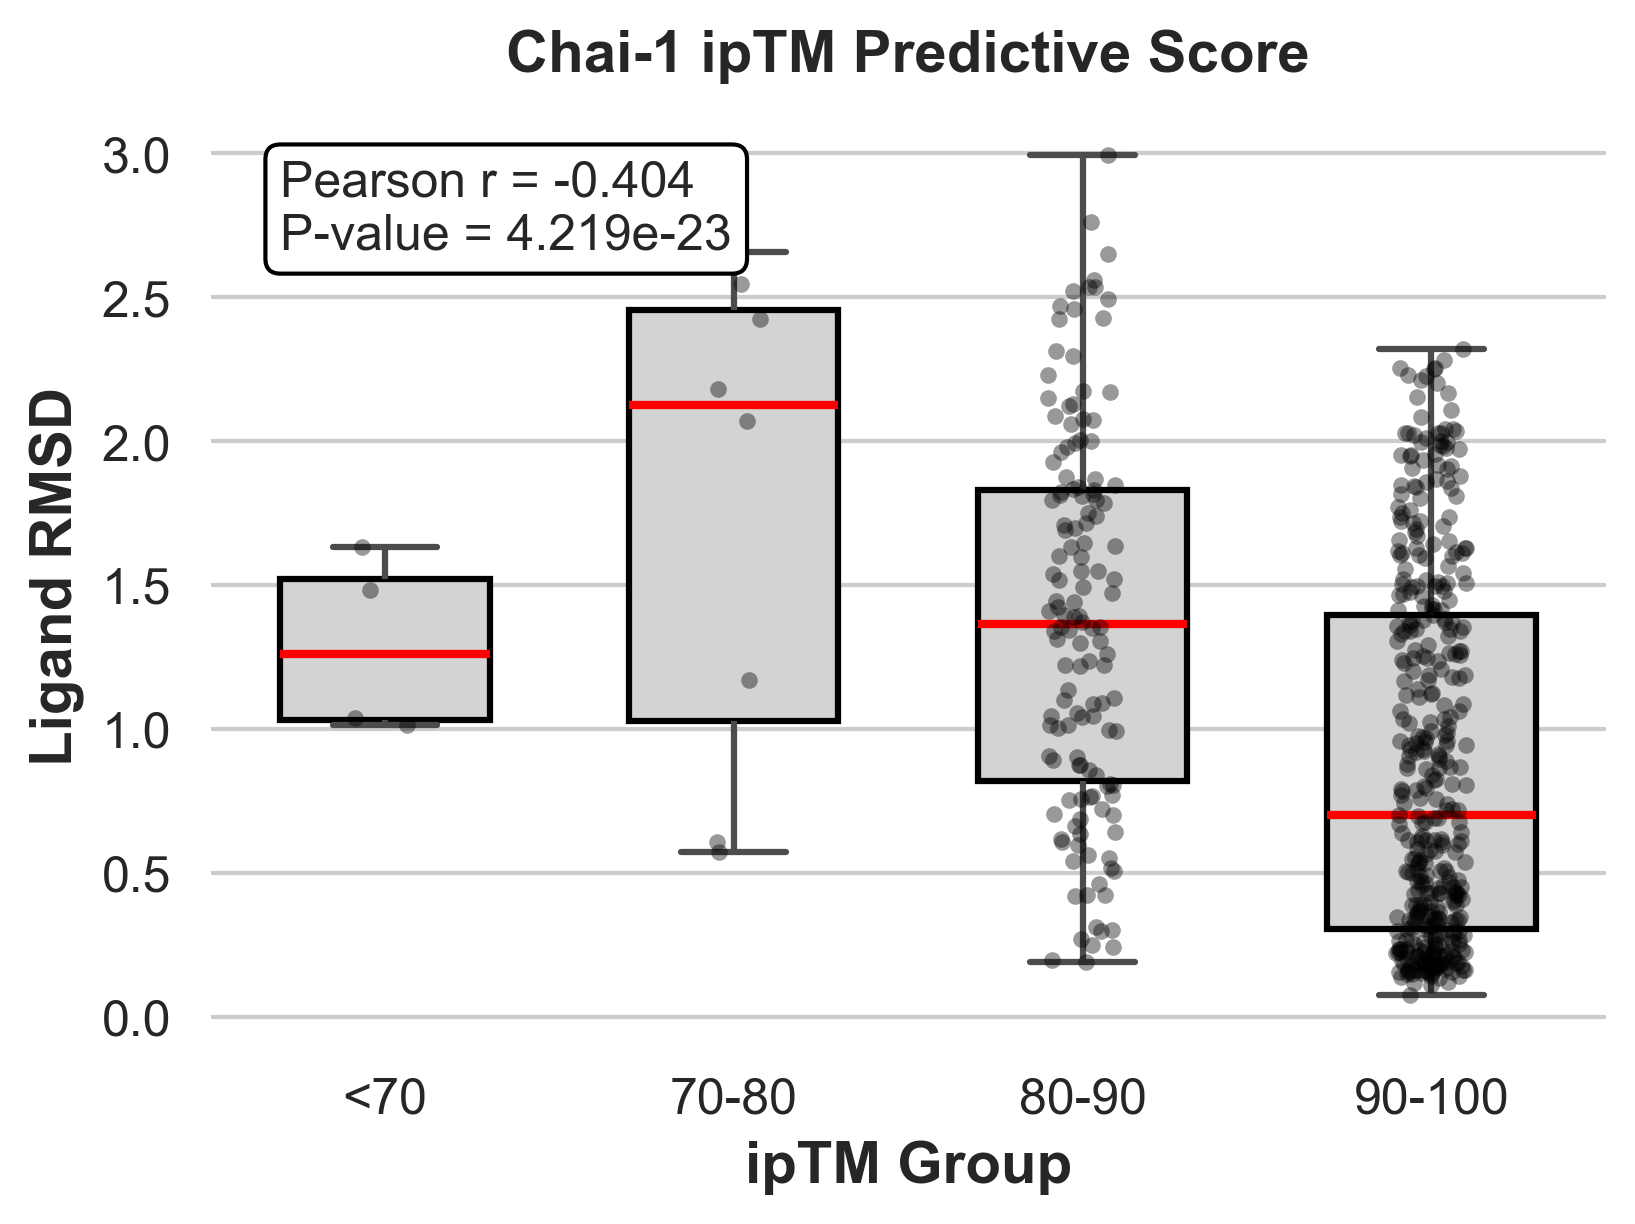

In [27]:
#Aim: Box plots for Chai-1 ipTM predictive scores or B-factor against L-RMSD. We can just change x to an appropriate column
#from excel file to assess different metric scores.

bins = [0, 70, 80, 90, 100]
labels = ["<70", "70-80", "80-90", "90-100"]

x = data.iloc[:, 16]  # iPTM
y = data.iloc[:, 9]   # L-RMSD


df = pd.DataFrame({"ipTM": x, "Ligand RMSD": y})
df.dropna(inplace=True)
df["ipTM Group"] = pd.cut(df["ipTM"], bins=bins, labels=labels, include_lowest=True)
bin_counts = df["ipTM Group"].value_counts().sort_index()
stats = df.groupby("ipTM Group")["Ligand RMSD"].agg(["mean", "std"])

print("Number of data points in each ipTM bin:")
print(bin_counts)
print(stats)

#Pearson's
corr_coeff, p_value = pearsonr(df["ipTM"], df["Ligand RMSD"])
print(f"Pearson Correlation Coefficient: {corr_coeff:.3f}")
print(f"P-value: {p_value:.3e}")

# Aesthetics for publication
sns.set(style="whitegrid", context="notebook")
plt.figure(figsize=(6, 4), dpi=300) 
sns.boxplot(x="ipTM Group", y="Ligand RMSD", data=df,  
            width=0.6, linewidth=1.5,  
            boxprops={'facecolor': 'lightgray', 'edgecolor': 'black'}, 
            whiskerprops={'linewidth': 1.5}, capprops={'linewidth': 1.5}, 
            medianprops={'color': 'red', 'linewidth': 2}, flierprops={'marker': 'o', 'alpha': 0.5})

sns.stripplot(x="ipTM Group", y="Ligand RMSD", data=df,  
              jitter=True, size=4, color="black", alpha=0.4)
plt.xlabel("ipTM Group", fontsize=14, fontweight='bold', fontname='Arial')
plt.ylabel("Ligand RMSD", fontsize=14, fontweight='bold', fontname='Arial')
plt.title("Chai-1 ipTM Predictive Score", fontsize=14, fontweight='bold', fontname='Arial', pad=10)
plt.xticks(fontsize=12, fontname='Arial')
plt.yticks(fontsize=12, fontname='Arial')

corr_text = f"Pearson r = {corr_coeff:.3f}\nP-value = {p_value:.3e}"
plt.text(0.05, 0.95, corr_text, transform=plt.gca().transAxes, fontsize=12, 
         verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))
sns.despine(trim=True, left=True, bottom=True)
plt.savefig("Chai_ipTM_vs_LRMSD.svg", format="svg", dpi=300, bbox_inches='tight') 
plt.savefig("Chai_ipTM_vs_LRMSD.png", format="png", dpi=600, bbox_inches='tight')  
plt.show()

/var/folders/6v/7hycfbhs6fg9jp_q0z6h9flm0000gp/T/ipykernel_34829/756859285.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(frameon=False, fontsize=12, loc='upper right')


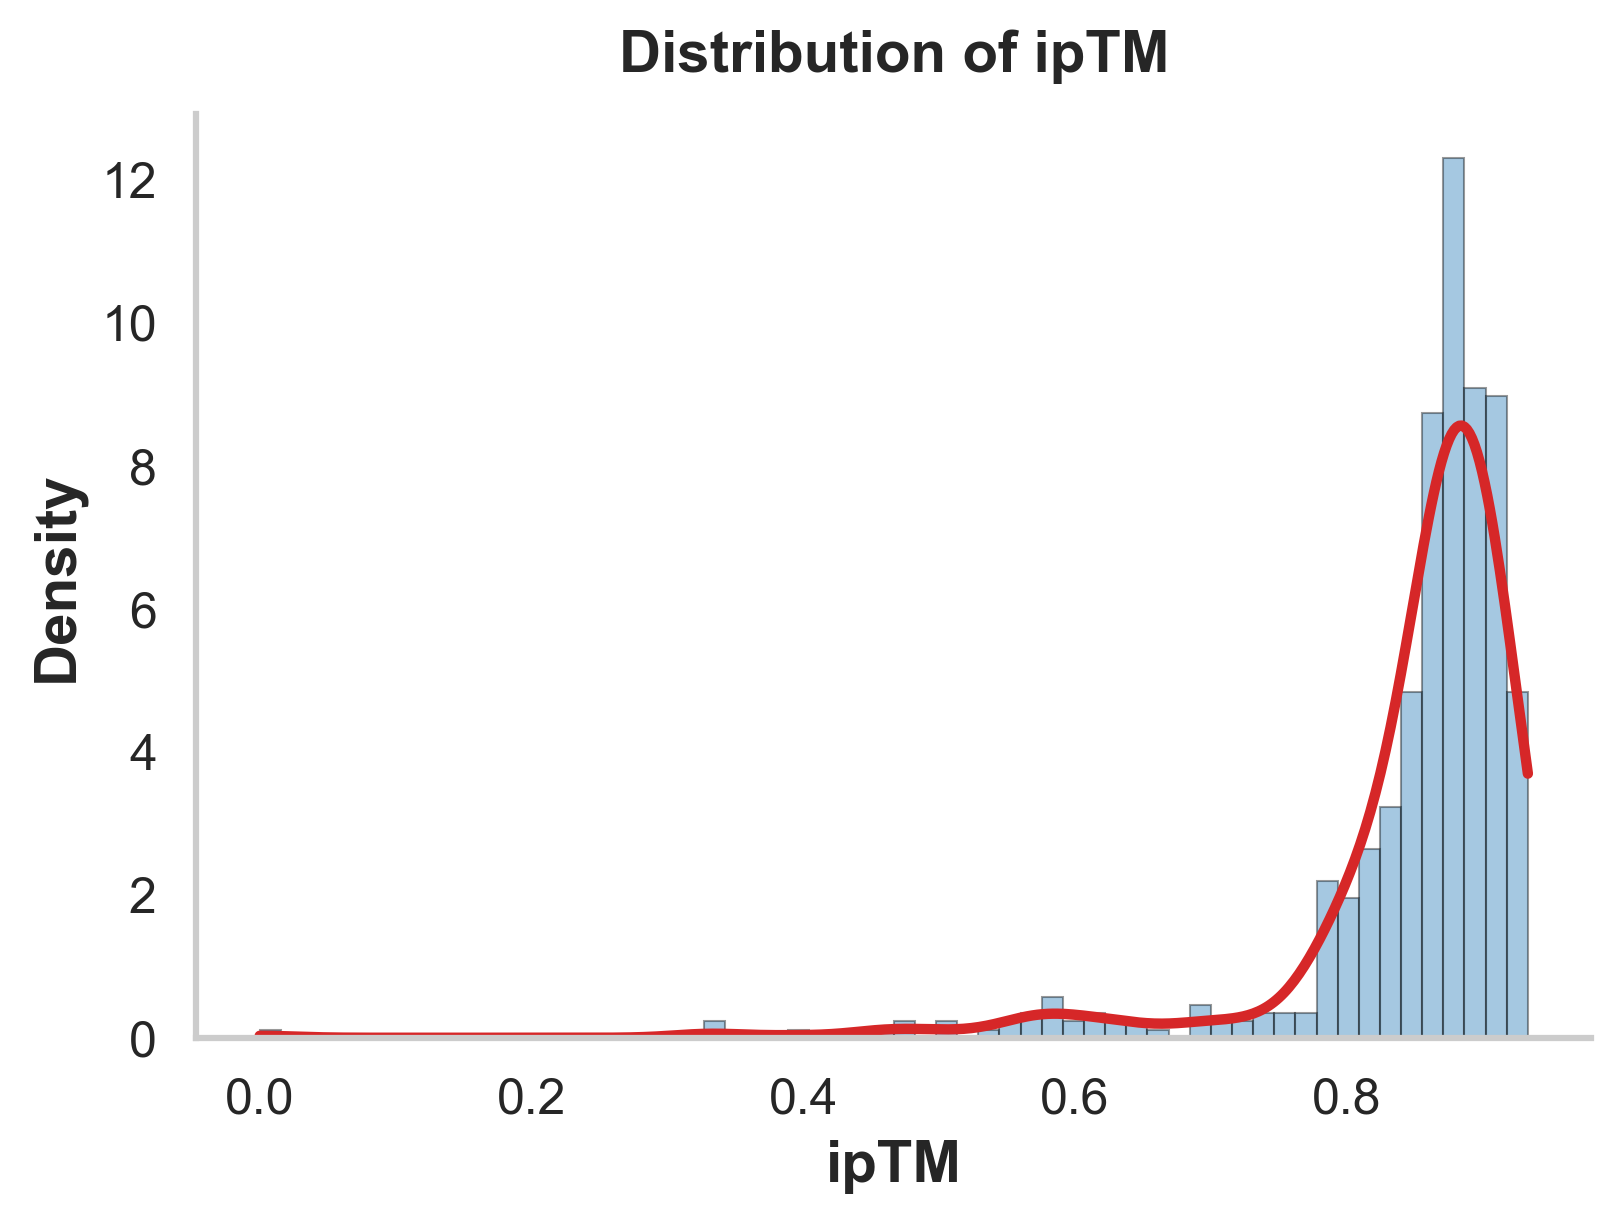

In [16]:
# Take density distribution curve for scores.
x = data.iloc[:, 15].dropna() 
plt.figure(figsize=(6, 4), dpi=300)
plt.hist(x, bins=60, density=True, alpha=0.4, color='#1f77b4', edgecolor='black', linewidth=0.5)

kde = gaussian_kde(x)
x_vals = np.linspace(min(x), max(x), 500)
kde_vals = kde(x_vals)
plt.plot(x_vals, kde_vals, color='#d62728', linewidth=2.5, linestyle='-', label="")
plt.xlabel('ipTM', fontsize=14, fontweight='bold', fontname='Arial')
plt.ylabel('Density', fontsize=14, fontweight='bold', fontname='Arial')
plt.title('Distribution of ipTM', fontsize=14, fontweight='bold', fontname='Arial', pad=10)
plt.xticks(fontsize=12, fontname='Arial')
plt.yticks(fontsize=12, fontname='Arial')
plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)
plt.tick_params(axis='both', direction='out', length=6, width=1.5, top=False, right=False)
plt.legend(frameon=False, fontsize=12, loc='upper right')
plt.savefig("ipTM_Distribution.svg", format="svg", dpi=300, bbox_inches='tight')  
plt.savefig("ipTM_Distribution.png", format="png", dpi=600, bbox_inches='tight') 
plt.show()

Number of data points in each TC bin:
TC Group
<0.3         181
0.3 - 0.5    306
0.5 - 0.7     68
>0.7           4
Name: count, dtype: int64

Statistics (Mean, Median & Standard Deviation) for iPTM in each TC bin:
    TC Group      mean    median       std
0       <0.3  0.874043  0.906756  0.091412
1  0.3 - 0.5  0.842402  0.873935  0.101413
2  0.5 - 0.7  0.825199  0.818100  0.035833
3       >0.7  0.860671  0.859339  0.007732


/var/folders/6v/7hycfbhs6fg9jp_q0z6h9flm0000gp/T/ipykernel_34829/1676550975.py:72: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(frameon=False, fontsize=12, loc='upper right')


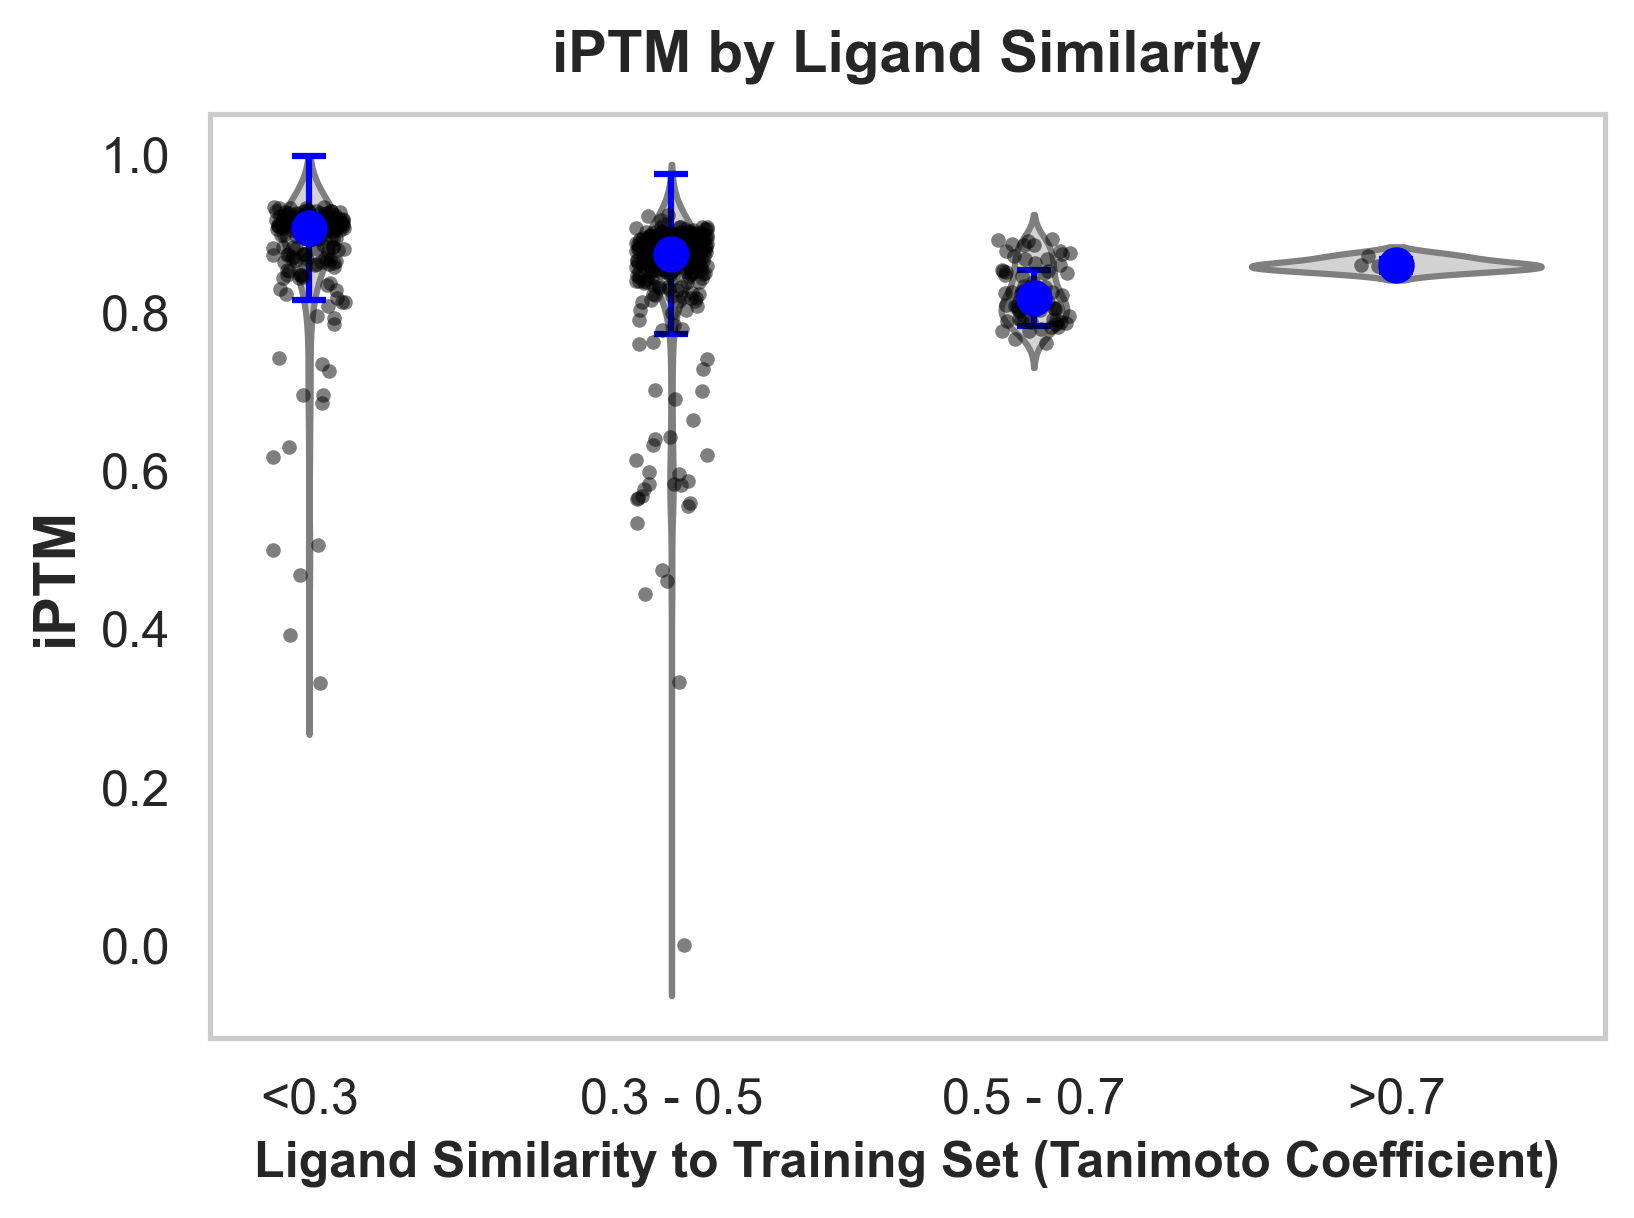

In [21]:
#Compares ipTM when molecules with different Tanimoto coefficients (compared to the training set) are co-folded.
file_path = "/Users/JB/Rotation_bkslab/250115_chaifold/20241209_mac1.xlsx"
data = pd.read_excel(file_path)

bins = [0, 0.3, 0.5, 0.7, 1]
labels = ["<0.3", "0.3 - 0.5", "0.5 - 0.7", ">0.7"]
x = data.iloc[:, 5]  # TC values
y = data.iloc[:, 15]  # iPTM values

df = pd.DataFrame({"iPTM": y, "TC": x})
df["TC Group"] = pd.cut(df["TC"], bins=bins, labels=labels, include_lowest=True)
nan_count = df["TC Group"].isna().sum()
if nan_count > 0:
    print(f"Warning: {nan_count} values in 'TC' are out of bin range and were not assigned to a group.")
    
bin_counts = df["TC Group"].value_counts().sort_index()
stats = df.groupby("TC Group", observed=False)["iPTM"].agg(["mean", "median", "std"]).reset_index()

print("Number of data points in each TC bin:")
print(bin_counts)
print("\nStatistics (Mean, Median & Standard Deviation) for iPTM in each TC bin:")
print(stats)

# Add plot aesthetics
sns.set(style="whitegrid", context="notebook")  
plt.figure(figsize=(6, 4), dpi=300) 
sns.violinplot(x="TC Group", y="iPTM", data=df, inner=None, color="lightgray", linewidth=1.5)
sns.stripplot(x="TC Group", y="iPTM", data=df, jitter=True, size=3.5, alpha=0.5, color="black")

for i, tc_group in enumerate(stats["TC Group"]):
    median_val = stats.loc[stats["TC Group"] == tc_group, "median"].values[0]
    std_val = stats.loc[stats["TC Group"] == tc_group, "std"].values[0]
    plt.scatter(i, median_val, color="blue", s=60, zorder=3, label="" if i == 0 else "")  
    plt.errorbar(i, median_val, yerr=std_val, color="blue", capsize=4, capthick=1.5, fmt='none', linewidth=1.5, zorder=2)

plt.xlabel("Ligand Similarity to Training Set (Tanimoto Coefficient)", fontsize=12, fontweight='bold', fontname='Arial')
plt.ylabel("iPTM", fontsize=14, fontweight='bold', fontname='Arial')
plt.title("iPTM by Ligand Similarity", fontsize=14, fontweight='bold', fontname='Arial', pad=10)
plt.xticks(fontsize=12, fontname='Arial')
plt.yticks(fontsize=12, fontname='Arial')
plt.grid(False)
plt.tick_params(axis='both', direction='out', length=6, width=1.5, top=False, right=False)
plt.legend(frameon=False, fontsize=12, loc='upper right')
plt.savefig("iPTM_by_Ligand_Similarity.svg", format="svg", dpi=300, bbox_inches='tight')
plt.savefig("iPTM_by_Ligand_Similarity.png", format="png", dpi=600, bbox_inches='tight') 
plt.show()